In [ ]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [ ]:
UPDATE_FREQ = 5000   #number of needles to toss before updating plot (natural numbers)
BOUND = 10  #length of square plot edge
BORDER = 0.05 * BOUND   #extra space around edge of plot area
NEEDLES = 5000  #total needles to plot during simulation
NEEDLE_LENGTH = 1   #length of needle; uses same "units" as bound and floorbaord width
FLOORBOARD_WIDTH = 2 #sapcing between floorbaord lines (twice needle length works out nicely for pi approximation)
FLOORBOARD_COLOR = 'black'  #personal preference
NEEDLE_INTERSECTING_COLOR = 'red' #personal preference
NEEDLE_NON_INTERSECTING_COLOR = 'green' #personal preference

In [ ]:
class Needle :
    #param  x       x-coordinate of needle's center
    #param  y       y-coordinate of needle's center
    #param  theta   angle of rotation of needle, measured in radians, ranges between 0 and pi
    #param  length  total length of needle
    def __init__(self, x=None, y=None, theta=None, length=NEEDLE_LENGTH) :
        #Sets coordinates and orientation to random if not specified
        if x is None :
            x = random.uniform(0, BOUND)    #BOUND is right edge
        if y is None :
            y = random.uniform(0, BOUND)    #BOUND is top edge
        if theta is None :
            theta = random.uniform(0, math.pi)  # (pi, 2pi] is redundant
        
        self.center = np.array([x, y])
        #components of needle as legs of right triangle (r cos(theta), r sin(theta))
        self.comp = np.array([length/2 * math.cos(theta), length/2 * math.sin(theta)])
        #add center to offset components, -/+ comp to flip about center
        self.endPoints = np.array([np.add(self.center, -1 * np.array(self.comp)), np.add(self.center, self.comp)])

    #return    whether endpoints cross y-boundary
    def intersectsY(self, y):
        return self.endPoints[0][1] < y and self.endPoints[1][1] > y

In [ ]:
class Buffon_Sim :
    #Constructor with instance variables
    def __init__(self) :
        #Instance variables
        self.floorboards = []   #stores y values of floorboard lines
        self.boards = int ((BOUND / FLOORBOARD_WIDTH) + 1)   #distance/unit + 1 for endcap
        self.needles = []   #stores Needle objects
        self.intersections = 0  #count of intersections between needles and floorboards
        #Text
        # window = "Buffon"
        # title = "Monte Carlo Simulation of Buffon's Needle Problem\n and estimation of pi"
        # desc = (str(NEEDLES) + " needles of length " + str(NEEDLE_LENGTH) +
        #         " uniformly distributed over a " + str(BOUND) + " by " + str(BOUND) + " area" +
        #         " with floorboards of width " + str(FLOORBOARD_WIDTH))
        #Setup plot
        fig = plt.figure(figsize=(8, 8))    #size of window large enough to view plot details
        fig.canvas.set_window_title(window) #window title
        fig.suptitle(title, size=16, ha='center')   #actually main title, but works better for formatting
        self.buffon = plt.subplot() #plot of needles with floorboards
        self.buffon.set_title(desc, style='italic', size=9, pad=5)  #description of current simulation conditions
        self.results_text = fig.text(0, 0, self.updateResults(), size=10)   #results in lower left
        self.buffon.set_xlim(0 - BORDER, BOUND + BORDER)    #x-axis limits
        self.buffon.set_ylim(0 - BORDER, BOUND + BORDER)    #y-axis limits
        plt.gca().set_aspect('equal')   #to preserve aspect ratio of axes

    #Plots all horizontal floorboards
    def plotFloorboards(self) :
        #Assuming horizontal floorboards
        for j in range(self.boards) :   #for every floorboard
            self.floorboards.append(0 + j * FLOORBOARD_WIDTH)   #start from 0 and add increments
            self.buffon.hlines(y=self.floorboards[j], xmin=0, xmax=BOUND, color=FLOORBOARD_COLOR, linestyle='--', linewidth=2.0) #horizontal lines, with x limits
    
    #Randomly creates and places a needle on the plot
    def tossNeedle(self) :
        needle = Needle()
        self.needles.append(needle)   #add a new needle to the array
        p1 = [needle.endPoints[0][0], needle.endPoints[1][0]]   #x-coords
        p2 = [needle.endPoints[0][1], needle.endPoints[1][1]]   #y-coords
        #intersection test
        for k in range (self.boards) :   #for every floorboard
            if needle.intersectsY(self.floorboards[k]) : #if intersection with horizontal board
                self.intersections += 1 #increment intersections
                self.buffon.plot(p1, p2, color=NEEDLE_INTERSECTING_COLOR, linewidth=0.5)
                return  #exit since intersection is known
        #only prints green needle if all intersection tests have failed
        self.buffon.plot(p1, p2, color=NEEDLE_NON_INTERSECTING_COLOR, linewidth=0.5)

    #Plots all needles and updates with given frequency
    def plotNeedles(self) : 
        for i in range(NEEDLES) :
            self.tossNeedle()   #toss a new needle
            self.results_text.set_text(self.updateResults(i+1)) #i starts at 0, so add 1 to start counting at 1
            if (i+1) % UPDATE_FREQ == 0 :   #update on intervals, couting using 1
                plt.pause(1/UPDATE_FREQ)    #reciprocal is time in seconds to pause for
    
    #updates results text given changes in plotting
    def updateResults(self, needlesTossed=0) :
        if self.intersections == 0 :    #to avoid division by 0 error
            sim_pi = 0  #default at 0
        else :
            sim_pi = (2 * NEEDLE_LENGTH * needlesTossed) / (FLOORBOARD_WIDTH * self.intersections)  
        error = abs(((math.pi - sim_pi) / math.pi) * 100)   #percent error formula
        return ("Intersections: " + str(self.intersections) +
                "\nTotal Needles: " + str(needlesTossed) +
                "\nApproximation of pi: " + str(sim_pi) +
                "\nError: " + str(error) + "%")

    #Plots floorboards and needles, then shows the resulting plot
    def plot(self) :
        #color legend
        #temporary lines for illustrating colors of plot elements
        legend_lines = [mlines.Line2D([], [], color=FLOORBOARD_COLOR, linestyle='--', lw=2),
                        mlines.Line2D([], [], color=NEEDLE_INTERSECTING_COLOR, lw=1),
                        mlines.Line2D([], [], color=NEEDLE_NON_INTERSECTING_COLOR, lw=1)]
        self.buffon.legend(legend_lines, ['floorboard', 'intersecting needle', 'non-intersecting needle'], loc=1, framealpha=0.9)   #top left and mostly opaque
        self.plotFloorboards()
        self.plotNeedles()
        plt.show()

In [ ]:
def main() :
    bsim = Buffon_Sim()
    bsim.plot()

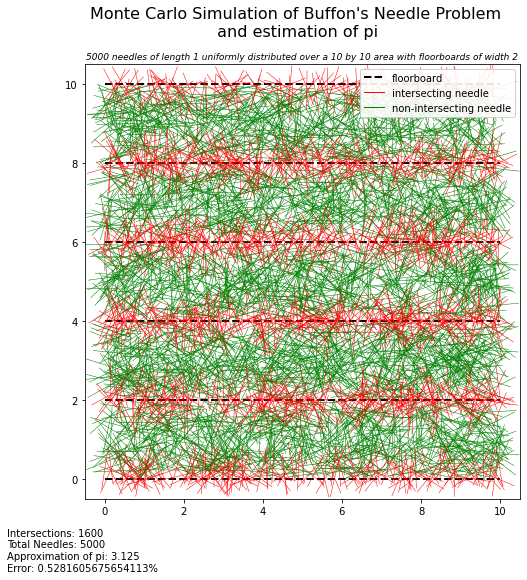

In [ ]:
main()